<a href="https://colab.research.google.com/github/JeremyKrick/traffic-trend-predictor/blob/prachi-dev/Final_Project_IOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U tensorflow

In [ ]:
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from collections import Counter

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from tensorflow import keras
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation
from keras.utils import pad_sequences
#from keras.wrappers.scikit_learn import KerasClassifier
#from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


In [ ]:
#!pip install keras==2.12.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path_uber_15='/content/drive/My Drive/ColabNotebooks/IOT/Final Project/uber-raw-data-janjune-15.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_uber = pd.read_csv(path_uber_15, delimiter = ",")
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


In [ ]:
unique_locid=df_uber['locationID'].unique()

In [ ]:
len(unique_locid)

262

In [ ]:
for loc in unique_locid:
  df_temp=df_uber.loc[df_uber['locationID']==loc]
  if (len(df_temp) < 100000):
    df_uber.loc[df_uber['locationID'] == loc, 'Traffic_conditions']='light'
  elif (len(df_temp)>=100000 and len(df_temp) <=250000 ):
    df_uber.loc[df_uber['locationID'] == loc, 'Traffic_conditions']='moderate'
  elif (len(df_temp)>=250000):
    df_uber.loc[df_uber['locationID'] == loc, 'Traffic_conditions']='heavy'

In [ ]:
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Traffic_conditions
0,B02617,2015-05-17 09:47:00,B02617,141,moderate
1,B02617,2015-05-17 09:47:00,B02617,65,light
2,B02617,2015-05-17 09:47:00,B02617,100,moderate
3,B02617,2015-05-17 09:47:00,B02774,80,moderate
4,B02617,2015-05-17 09:47:00,B02617,90,moderate


In [ ]:
print(len(df_uber.loc[df_uber['Traffic_conditions']=='light']))
print(len(df_uber.loc[df_uber['Traffic_conditions']=='moderate']))
print(len(df_uber.loc[df_uber['Traffic_conditions']=='heavy']))

3392312
4687102
6191065


In [ ]:
df_uber.loc[(df_uber['Traffic_conditions']!='light') & (df_uber['Traffic_conditions']!='moderate') & (df_uber['Traffic_conditions']!='heavy' )]

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Traffic_conditions


In [ ]:
df_uber['Datetime']= pd.to_datetime(df_uber['Pickup_date'])

In [ ]:
df_uber.dtypes

Dispatching_base_num            object
Pickup_date                     object
Affiliated_base_num             object
locationID                       int64
Traffic_conditions              object
Datetime                datetime64[ns]
dtype: object

In [ ]:
#convert datetime to epoch/unix time
from datetime import datetime
df_uber['unix']=df_uber['Datetime'].astype(int) / 10**9

In [ ]:
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Traffic_conditions,Datetime,unix
0,B02617,2015-05-17 09:47:00,B02617,141,moderate,2015-05-17 09:47:00,1.431856e+09
1,B02617,2015-05-17 09:47:00,B02617,65,light,2015-05-17 09:47:00,1.431856e+09
2,B02617,2015-05-17 09:47:00,B02617,100,moderate,2015-05-17 09:47:00,1.431856e+09
3,B02617,2015-05-17 09:47:00,B02774,80,moderate,2015-05-17 09:47:00,1.431856e+09
4,B02617,2015-05-17 09:47:00,B02617,90,moderate,2015-05-17 09:47:00,1.431856e+09


In [ ]:
random_sample = df_uber.sample(frac=0.01, random_state=42)

In [ ]:
random_sample.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Traffic_conditions,Datetime,unix
14294,B02764,2015-04-04 23:39:00,B02764,41,light,2015-04-04 23:39:00,1.428191e+09
8730642,B02617,2015-03-23 08:35:00,B02617,164,heavy,2015-03-23 08:35:00,1.427100e+09
1096207,B02764,2015-06-20 20:01:00,B02764,163,heavy,2015-06-20 20:01:00,1.434830e+09
12502142,B02764,2015-02-09 19:55:29,B02725,129,light,2015-02-09 19:55:29,1.423512e+09
2789937,B02617,2015-06-09 21:25:00,B02617,132,heavy,2015-06-09 21:25:00,1.433885e+09


In [ ]:
df_uber['Pickup_date']= pd.to_datetime(df_uber['Pickup_date'])

In [ ]:
df_uber.dtypes

Dispatching_base_num            object
Pickup_date             datetime64[ns]
Affiliated_base_num             object
locationID                       int64
Traffic_conditions              object
Datetime                datetime64[ns]
unix                           float64
dtype: object

<Axes: >

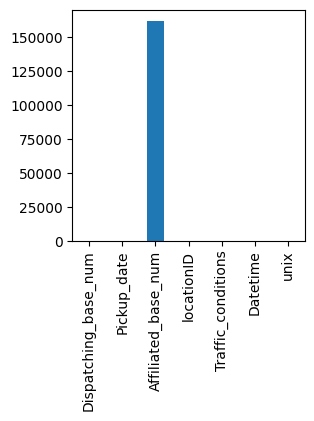

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(3,3))
df_uber.isna().sum().plot.bar()

In [ ]:
df_uber = df_uber.dropna()

<Axes: >

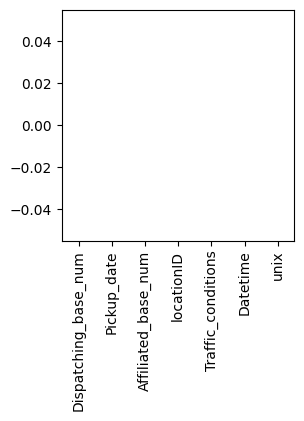

In [ ]:
f, ax = plt.subplots(figsize=(3,3))
df_uber.isna().sum().plot.bar()

In [ ]:
df_uber.duplicated().sum()

896732

In [ ]:
df_uber.drop_duplicates(inplace=True)

In [ ]:
df_uber.duplicated().sum()

0

In [ ]:
df_uber["month"] = df_uber["Pickup_date"].dt.month_name()
df_uber["weekday"] = df_uber["Pickup_date"].dt.day_name()
df_uber['hour'] = df_uber['Pickup_date'].dt.hour
df_uber['month_day'] = df_uber['Pickup_date'].apply(lambda pickup: pickup.strftime('%m-%d').split('-'))
df_uber['Monthumn'] = [month_day [0] for month_day in df_uber['month_day']]
df_uber['Day'] = [month_day [1] for month_day in df_uber['month_day']]

In [ ]:
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Traffic_conditions,Datetime,unix,month,weekday,hour,month_day,Monthumn,Day
0,B02617,2015-05-17 09:47:00,B02617,141,moderate,2015-05-17 09:47:00,1.431856e+09,May,Sunday,9,"[05, 17]",05,17
1,B02617,2015-05-17 09:47:00,B02617,65,light,2015-05-17 09:47:00,1.431856e+09,May,Sunday,9,"[05, 17]",05,17
2,B02617,2015-05-17 09:47:00,B02617,100,moderate,2015-05-17 09:47:00,1.431856e+09,May,Sunday,9,"[05, 17]",05,17
3,B02617,2015-05-17 09:47:00,B02774,80,moderate,2015-05-17 09:47:00,1.431856e+09,May,Sunday,9,"[05, 17]",05,17
4,B02617,2015-05-17 09:47:00,B02617,90,moderate,2015-05-17 09:47:00,1.431856e+09,May,Sunday,9,"[05, 17]",05,17


In [ ]:
df_uber["month"].value_counts()

June        2571771
May         2483980
February    2141306
April       2112705
March       2062639
January     1839151
Name: month, dtype: int64

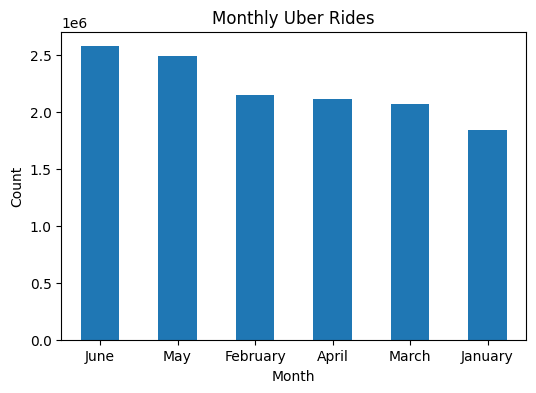

In [ ]:
import matplotlib.pyplot as plt

# Plot data
counts = df_uber["month"].value_counts()
plt.figure(figsize=(6, 4))  # Set the figure size
counts.plot(kind="bar")  # Use skyblue color
plt.xlabel("Month")  # X-axis label
plt.ylabel("Count")  # Y-axis label
plt.title("Monthly Uber Rides")  # Plot title
plt.xticks(rotation=0)  # Set X-axis label rotation

# Show the plot
plt.show()

In [ ]:
monthweek = pd.crosstab(index=df_uber["month"], columns=df_uber["weekday"])
monthweek

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
month,,,,,,,
April,315002,238429,324545,273560,372522,250632,338015
February,360136,264693,354962,284432,323955,276956,276172
January,325261,182785,369693,219884,316857,188802,235869
June,371225,375312,399377,334434,357782,405500,328141
March,309631,269931,314785,313865,277026,320634,256767
May,430134,255501,464298,390391,337607,290004,316045


<Figure size 600x400 with 0 Axes>

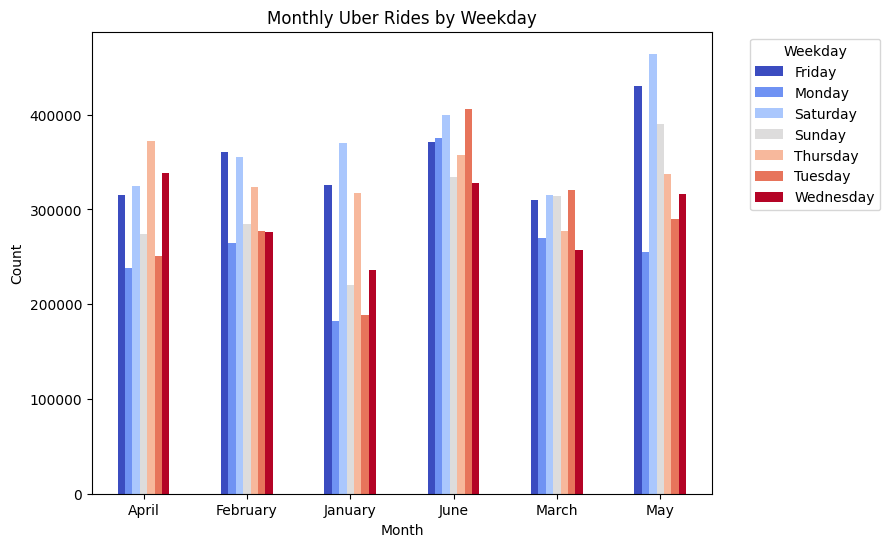

In [ ]:
plt.figure(figsize=(6, 4))  # Set the figure size
monthweek.plot(kind="bar", figsize=(8, 6), cmap='coolwarm')  # Use a coolwarm color palette
plt.xlabel("Month")  # X-axis label
plt.ylabel("Count")  # Y-axis label
plt.title("Monthly Uber Rides by Weekday")  # Plot title
plt.xticks(rotation=0)  # Set X-axis label rotation

# Show the plot
plt.legend(title="Weekday", bbox_to_anchor=(1.05, 1), loc='upper left')  # Add legend
plt.show()

In [ ]:
summary = df_uber.groupby(['weekday', 'hour'], as_index=False).size()
summary.head()

,weekday,hour,size
0,Friday,0,78936
1,Friday,1,44064
2,Friday,2,26942
3,Friday,3,18845
4,Friday,4,22798


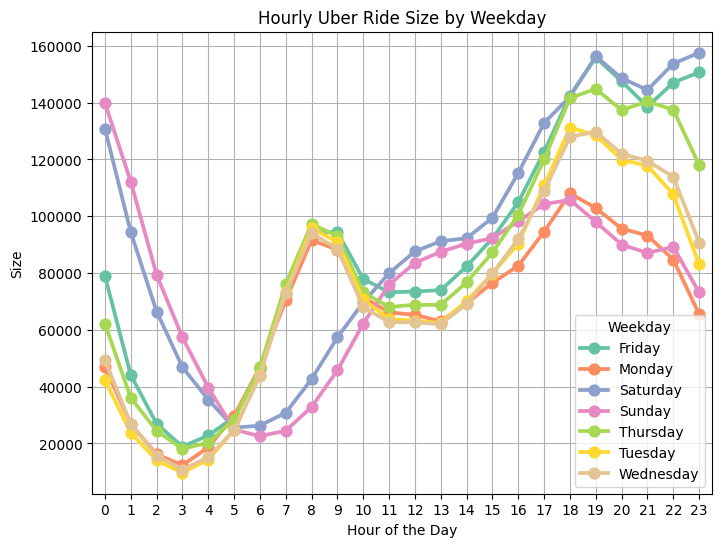

In [ ]:
import seaborn as sns

# Set the figure size
plt.figure(figsize=(8, 6))

# Create the point plot
sns.pointplot(x="hour", y="size", hue="weekday", data=summary, palette="Set2")

# Add labels and title
plt.xlabel("Hour of the Day")
plt.ylabel("Size")
plt.title("Hourly Uber Ride Size by Weekday")

# Customize the legend
plt.legend(title="Weekday")

# Show the plot
plt.grid(True)  # Add grid lines
plt.show()

In [ ]:
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Traffic_conditions,Datetime,unix,month,weekday,hour,month_day,Monthumn,Day
0,B02617,2015-05-17 09:47:00,B02617,141,moderate,2015-05-17 09:47:00,1.431856e+09,May,Sunday,9,"[05, 17]",05,17
1,B02617,2015-05-17 09:47:00,B02617,65,light,2015-05-17 09:47:00,1.431856e+09,May,Sunday,9,"[05, 17]",05,17
2,B02617,2015-05-17 09:47:00,B02617,100,moderate,2015-05-17 09:47:00,1.431856e+09,May,Sunday,9,"[05, 17]",05,17
3,B02617,2015-05-17 09:47:00,B02774,80,moderate,2015-05-17 09:47:00,1.431856e+09,May,Sunday,9,"[05, 17]",05,17
4,B02617,2015-05-17 09:47:00,B02617,90,moderate,2015-05-17 09:47:00,1.431856e+09,May,Sunday,9,"[05, 17]",05,17


In [ ]:
df_uber.to_csv('/content/drive/My Drive/ColabNotebooks/IOT/Final Project/uber-raw-data-janjune-15_trafficcond.csv', index = None)

## Model 1 - Classify the traffic conditions (e.g., light, moderate, heavy) in different zones of NYC using Machine Learning Model

In [ ]:
random_sample = df_uber.sample(frac=0.01, random_state=42)
random_sample.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Traffic_conditions,Datetime,unix,month,weekday,hour,month_day,Monthumn,Day
8799280,B02764,2015-02-04 17:48:48,B02764,219,light,2015-02-04 17:48:48,1.423072e+09,February,Wednesday,17,"[02, 04]",02,04
7479949,B02764,2015-04-19 05:34:00,B02764,262,moderate,2015-04-19 05:34:00,1.429422e+09,April,Sunday,5,"[04, 19]",04,19
8955397,B02764,2015-06-25 13:05:00,B02670,140,moderate,2015-06-25 13:05:00,1.435238e+09,June,Thursday,13,"[06, 25]",06,25
8303321,B02682,2015-05-02 18:17:00,B02682,112,moderate,2015-05-02 18:17:00,1.430591e+09,May,Saturday,18,"[05, 02]",05,02
13462605,B02765,2015-06-17 18:51:00,B02765,90,moderate,2015-06-17 18:51:00,1.434567e+09,June,Wednesday,18,"[06, 17]",06,17


In [ ]:
print(len(random_sample.loc[random_sample['Traffic_conditions']=='light']))
print(len(random_sample.loc[random_sample['Traffic_conditions']=='moderate']))
print(len(random_sample.loc[random_sample['Traffic_conditions']=='heavy']))

32901
43873
55342


In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC   # The SVM Classifier from Scikit
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
#% matplotlib inline
X = random_sample[['unix','locationID']]
#X = random_sample['locationID']
scaler = MinMaxScaler()
X_new = scaler.fit_transform(X)
y = random_sample['Traffic_conditions']
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
X_train, X_test, Y_train, Y_test = train_test_split(X_new, y, test_size = 0.2, random_state = 323)


In [ ]:
#classifier = SVC(kernel = 'rbf', random_state = 45)
classifier = DecisionTreeClassifier(max_depth=10)
classifier.fit(X_train, Y_train)
#Predicting the Test Set
Y_pred = classifier.predict(X_test)

In [ ]:
print("Accuracy is {}".format(accuracy_score(Y_test, Y_pred)))

Accuracy is 0.9570466242809567


<Axes: >

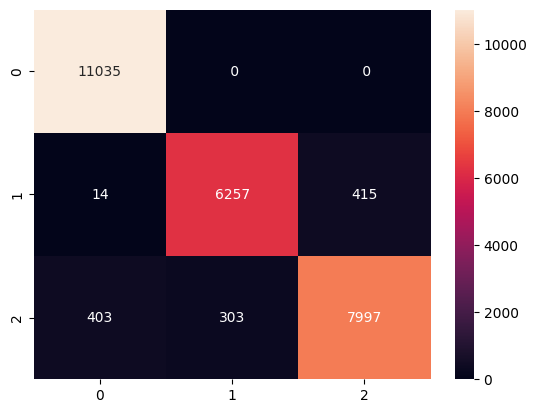

In [ ]:
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm,annot=True,fmt='2.0f')

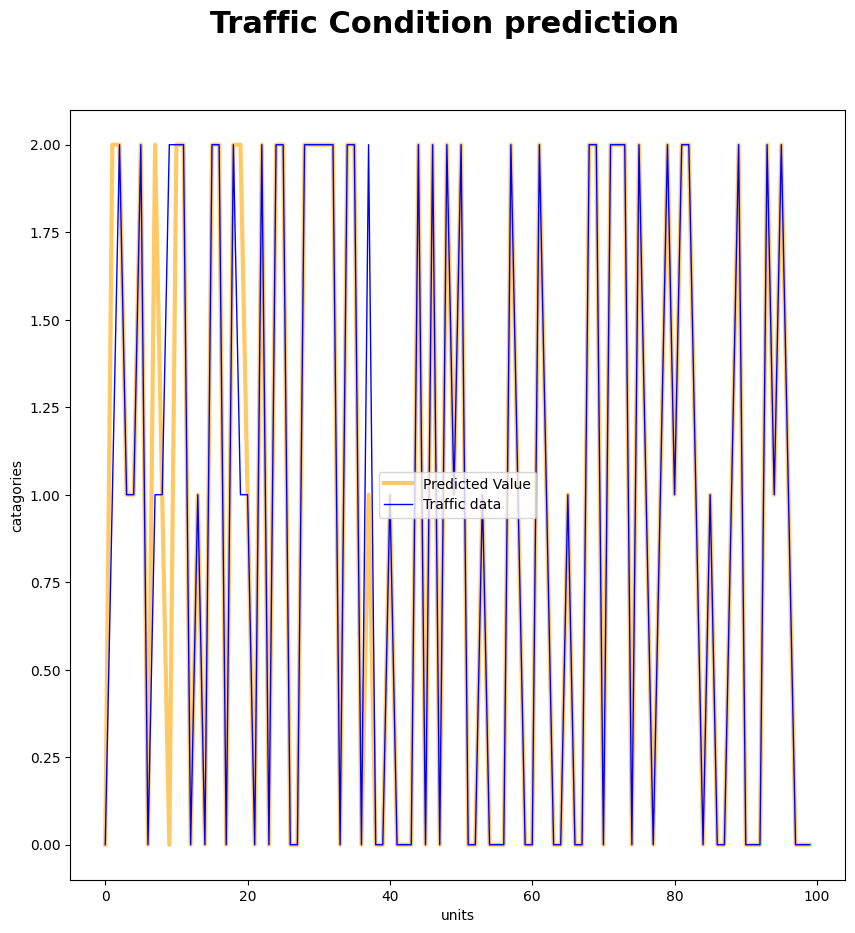

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Traffic Condition prediction', fontsize=22, fontweight='bold')
#ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot( Y_pred[0:100], label='Predicted Value', linewidth=3, color='orange', alpha=0.6)
ax.plot(Y_test[0:100], label='Traffic data',linewidth=1, color='blue')
#ax.plot(t_tot, hypoglycemiaTH, label='Hypoglycemia threshold')
ax.set_xlabel('units')
ax.set_ylabel('catagories')
ax.legend()

In [ ]:
df_ml_predict=pd.DataFrame()
df_ml_predict['Traffic_Condition_Actual']=Y_test
df_ml_predict['Traffic_Condition_Predicted']=Y_pred

In [ ]:
df_ml_predict.to_csv('/content/drive/My Drive/ColabNotebooks/IOT/Final Project/Final_Project_ML_Prediction.csv', index = None)

## Sample code for model prediction using Deep Learning

In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from keras.layers import Dense

# define the  model
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, Y_train, epochs=10, batch_size=16, verbose=2)
# evaluate the keras model
_, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/10
6606/6606 - 9s - loss: 0.2948 - accuracy: 0.2480 - 9s/epoch - 1ms/step
Epoch 2/10
6606/6606 - 9s - loss: 0.2436 - accuracy: 0.2480 - 9s/epoch - 1ms/step
Epoch 3/10
6606/6606 - 9s - loss: 0.1833 - accuracy: 0.2480 - 9s/epoch - 1ms/step
Epoch 4/10
6606/6606 - 9s - loss: 0.0953 - accuracy: 0.2480 - 9s/epoch - 1ms/step
Epoch 5/10
6606/6606 - 9s - loss: -7.8092e-03 - accuracy: 0.2480 - 9s/epoch - 1ms/step
Epoch 6/10
6606/6606 - 9s - loss: -1.1664e-01 - accuracy: 0.2480 - 9s/epoch - 1ms/step
Epoch 7/10
6606/6606 - 9s - loss: -2.3807e-01 - accuracy: 0.2480 - 9s/epoch - 1ms/step
Epoch 8/10
6606/6606 - 8s - loss: -3.7683e-01 - accuracy: 0.2480 - 8s/epoch - 1ms/step
Epoch 9/10
6606/6606 - 9s - loss: -5.3375e-01 - accuracy: 0.2480 - 9s/epoch - 1ms/step
Epoch 10/10
6606/6606 - 9s - loss: -7.0937e-01 - accuracy: 0.2480 - 9s/epoch - 1ms/step
Accuracy: 25.30


## Model 2 - Time Series Prediction – Forecast the future demand for Uber pickups across NYC using LSTM.

In [ ]:
month_day_group = df_uber.groupby(by = ['Monthumn', 'Day']).size().unstack()
month_day_group

Day,01,02,03,04,05,06,07,08,09,10,...,22,23,24,25,26,27,28,29,30,31
Monthumn,,,,,,,,,,,,,,,,,,,,,
01,54369.0,37789.0,56440.0,39362.0,41045.0,50428.0,59771.0,68634.0,67709.0,75676.0,...,63139.0,69251.0,77850.0,55737.0,41921.0,24422.0,58188.0,66429.0,80565.0,88907.0
02,73855.0,66435.0,67531.0,64330.0,77814.0,82677.0,78290.0,60590.0,59971.0,62595.0,...,63870.0,68709.0,76462.0,72202.0,80585.0,85703.0,85069.0,NaN,NaN,NaN
03,65013.0,53372.0,67373.0,65268.0,69742.0,74966.0,74097.0,56893.0,50523.0,64741.0,...,63765.0,56395.0,59494.0,67387.0,71295.0,77449.0,83857.0,69077.0,58436.0,71292.0
04,64412.0,68539.0,71292.0,65223.0,55686.0,51019.0,62838.0,66425.0,71239.0,75417.0,...,74769.0,83122.0,90534.0,96260.0,81836.0,61267.0,64323.0,70306.0,77116.0,NaN
05,85097.0,95693.0,74748.0,61799.0,70715.0,74536.0,79739.0,83794.0,90412.0,74822.0,...,80253.0,73776.0,64869.0,56636.0,68003.0,80519.0,86293.0,89904.0,95821.0,89357.0
06,85030.0,87861.0,79747.0,85836.0,93082.0,93713.0,82361.0,71611.0,76059.0,80039.0,...,70212.0,84311.0,83254.0,90266.0,91319.0,119208.0,85442.0,69605.0,76246.0,NaN


In [ ]:
## Aggregate results to form a time-series
month_day_series = [month_day_group.iloc[r,:] for r in range(month_day_group.shape[0])]

In [ ]:
month_day_series[0][0:10]

Day
01    54369.0
02    37789.0
03    56440.0
04    39362.0
05    41045.0
06    50428.0
07    59771.0
08    68634.0
09    67709.0
10    75676.0
Name: 01, dtype: float64

In [ ]:
month_day_list=[]
for month in month_day_series:
  for days in month:
    month_day_list.append(days)

In [ ]:
len(month_day_list)

186

In [ ]:
# month_day_list = [days for month in month_day_series for days in month]
# len(month_day_list)

In [ ]:
nan_indx=np.argwhere(np.isnan(month_day_list) == True)
len(nan_indx)

5

In [ ]:
## Remove missing values: here missing values are the days when a month is shorter than 31 days.
remove_inds = list(nan_indx.reshape((1,len(nan_indx)))[0])
remove_inds

[59, 60, 61, 123, 185]

In [ ]:
month_day_list_nonan = [month_day_list[i] for i,j in enumerate(month_day_list) if i not in remove_inds]
len(month_day_list_nonan)

181

In [ ]:
## Convert time-series into data-frame for modeling process
df_uber_final = pd.DataFrame({'Days': range(1,len(month_day_list_nonan)+1), 'UberPickups': month_day_list_nonan})
df_uber_final.head()

,Days,UberPickups
0,1,54369.0
1,2,37789.0
2,3,56440.0
3,4,39362.0
4,5,41045.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

## Split into train-test set:
train_jan_june = df_uber_final.iloc[0:167,1:2].values
test_jan_june = df_uber_final.iloc[167:,1:2].values

print ('Training data: ', train_jan_june.shape)
print ('Testing data: ', test_jan_june.shape)

## Feature-scaling:
mms = MinMaxScaler(feature_range = (0,1))
train_jan_june_scaled = mms.fit_transform(train_jan_june)

Training data:  (167, 1)
Testing data:  (14, 1)


In [ ]:
ph=10

In [ ]:
x_train = []
y_train = []

for rides in range(14, train_jan_june.shape[0]):
    x_train.append(train_jan_june_scaled[rides-14:rides,0])
    y_train.append(train_jan_june_scaled[rides,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, newshape = (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
## Import required modules:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import GridSearchCV
import time

In [ ]:
np.random.seed(11)
t_start = time.time()

def build_rnn(num_units, input_x, input_y, drpout, epochs, size_of_batch, optimizer, loss):

    regressor = Sequential()

    ## Adding first LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = True, input_shape = (input_x.shape[1],1)))
    regressor.add(Dropout(drpout))

    ## Adding second LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = True))
    regressor.add(Dropout(drpout))

    ## Adding third LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = True))
    regressor.add(Dropout(drpout))

    ## Adding fourth LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = True))
    regressor.add(Dropout(drpout))

    ## Adding fifth LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = False))
    regressor.add(Dropout(drpout))

    ## Adding o/p layer:
    regressor.add(Dense(units = 1))

    ## Compiling RNN:
    regressor.compile(optimizer = optimizer, loss = loss)

    ## Fitting RNN to training set:
    regressor.fit(x = input_x, y = input_y, epochs = epochs, batch_size = size_of_batch)

    return regressor

regressor = build_rnn(num_units = 40, input_x = x_train, input_y = y_train, drpout = 0.2, epochs = 1000, size_of_batch = 16, optimizer = 'adam', loss = 'mean_squared_error')

print (time.time() - t_start)

Epoch 1/1000
10/10 [==============================] - 9s 28ms/step - loss: 0.2047
Epoch 2/1000
10/10 [==============================] - 0s 29ms/step - loss: 0.0532
Epoch 3/1000
10/10 [==============================] - 0s 28ms/step - loss: 0.0329
Epoch 4/1000
10/10 [==============================] - 0s 28ms/step - loss: 0.0294
Epoch 5/1000
10/10 [==============================] - 0s 29ms/step - loss: 0.0310
Epoch 6/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0297
Epoch 7/1000
10/10 [==============================] - 0s 35ms/step - loss: 0.0267
Epoch 8/1000
10/10 [==============================] - 0s 43ms/step - loss: 0.0252
Epoch 9/1000
10/10 [==============================] - 0s 42ms/step - loss: 0.0229
Epoch 10/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0232
Epoch 11/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.0241
Epoch 12/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.0237
Epoch 13/1000

In [ ]:
# using last 14 values to predict the next value
# test_inputs_adjusted_predictionwindow = df_uber_final[len(uber_jan_june_final) - len(test_jan_june) - ph:]['UberPickups'].values
# test_inputs_adjusted_predictionwindow
adjusted_inputs = df_uber_final[len(df_uber_final) - len(test_jan_june) - 14:]['UberPickups'].values
adjusted_inputs = adjusted_inputs.reshape(-1,1)
adjusted_inputs = mms.transform(adjusted_inputs)
adjusted_inputs[0:10]

array([[0.65726947],
       [0.72960772],
       [0.81569131],
       [0.82318768],
       [0.68832419],
       [0.56061254],
       [0.61345546],
       [0.66073847],
       [0.79777604],
       [0.82472022]])

In [ ]:
# test_inputs_adjusted_predictionwindow = test_inputs_adjusted_predictionwindow.reshape(-1,1)
# test_inputs_adjusted_predictionwindow = mms.transform(test_inputs_adjusted_predictionwindow)
# test_inputs_adjusted_predictionwindow[0:5]

In [ ]:
# ## Create properly structured test set:
# x_test = []
# for rides in range(ph,len(test_inputs_adjusted_predictionwindow)):
#     x_test.append(test_inputs_adjusted_predictionwindow[rides-ph:rides,0])
# print(x_test)
## Create properly structured test set:
x_test = []
for rides in range(14,29):
    x_test.append(adjusted_inputs[rides-14:rides,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, newshape = (x_test.shape[0], x_test.shape[1], 1))
x_test.shape


(15, 14, 1)

In [ ]:
# x_test = np.array(x_test)
# x_test = np.reshape(x_test, newshape = (x_test.shape[0], x_test.shape[1], 1))
# x_test.shape

In [ ]:
## Make prediction for test set and bring values back to original scale
pred = regressor.predict(x_test)
pred = mms.inverse_transform(pred)

## Check RMSE on test-set
residuals = pred[0:-1] - test_jan_june
rmse = np.sqrt(np.mean(residuals**2))
rmse

1/1 [==============================] - 2s 2s/step


9625.37077798971

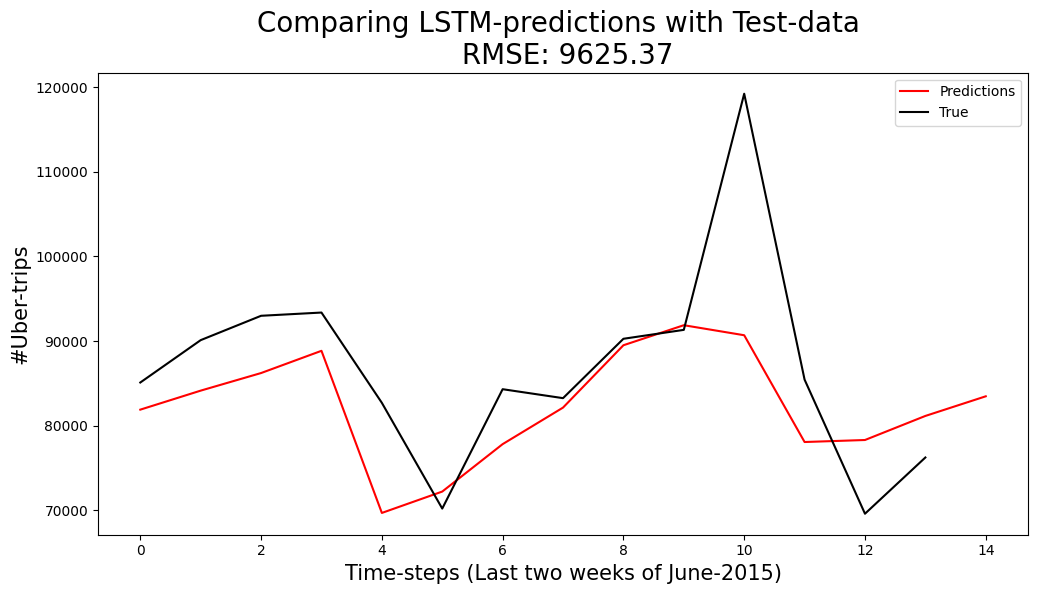

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))

e = [i*0.05 for i in pred]
ax.plot(pred, color = 'red', label = 'Predictions')
#ax.errorbar(x = range(15), y = pred, yerr = e, fmt = '*', color = 'r')
ax.plot(test_jan_june, color = 'black', label = 'True')

ax.set_xlabel('Time-steps (Last two weeks of June-2015)', fontsize = 15)
ax.set_ylabel('#Uber-trips', fontsize = 15)
ax.set_title('Comparing LSTM-predictions with Test-data \n RMSE: {}'.format(np.round(rmse,2)), fontsize = 20)

ax.legend()
plt.show()

In [ ]:
len(pred)

15

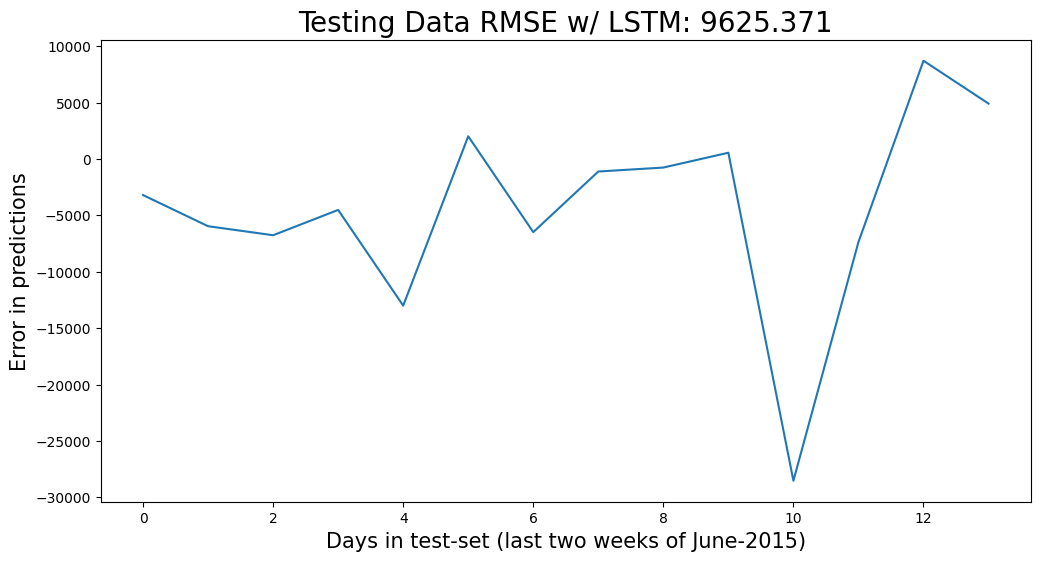

In [ ]:
fig ,ax = plt.subplots(figsize = (12,6))
ax.plot(residuals)

ax.set_xlabel('Days in test-set (last two weeks of June-2015)', fontsize = 15)
ax.set_ylabel('Error in predictions', fontsize = 15)
ax.set_title('Testing Data RMSE w/ LSTM: {}'.format(round(rmse, 3)), fontsize = 20)
plt.show()

5/5 [==============================] - 0s 11ms/step


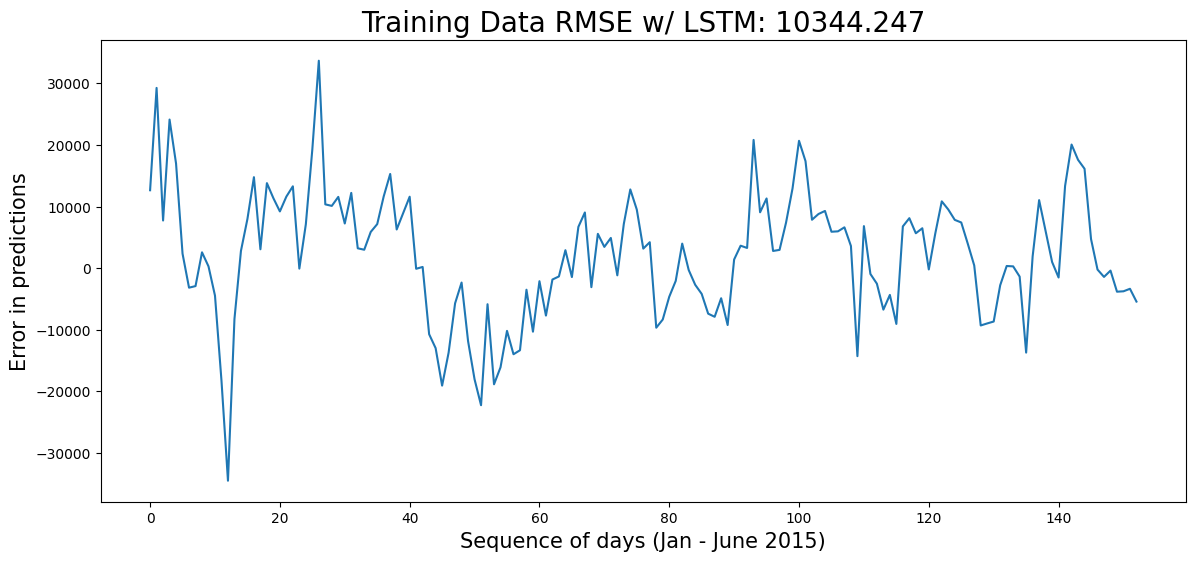

In [ ]:
pred_train = regressor.predict(x_train)
pred_train = mms.inverse_transform(pred_train)

residuals_train = pred_train - train_jan_june[0:-14]
rmse_train = np.sqrt(np.mean(residuals_train**2))

fig, ax = plt.subplots(figsize = (14,6))
ax.plot(residuals_train)
ax.set_xlabel('Sequence of days (Jan - June 2015)', fontsize = 15)
ax.set_ylabel('Error in predictions', fontsize = 15)
ax.set_title('Training Data RMSE w/ LSTM: {}'.format(round(rmse_train,3)), fontsize = 20)
plt.show()

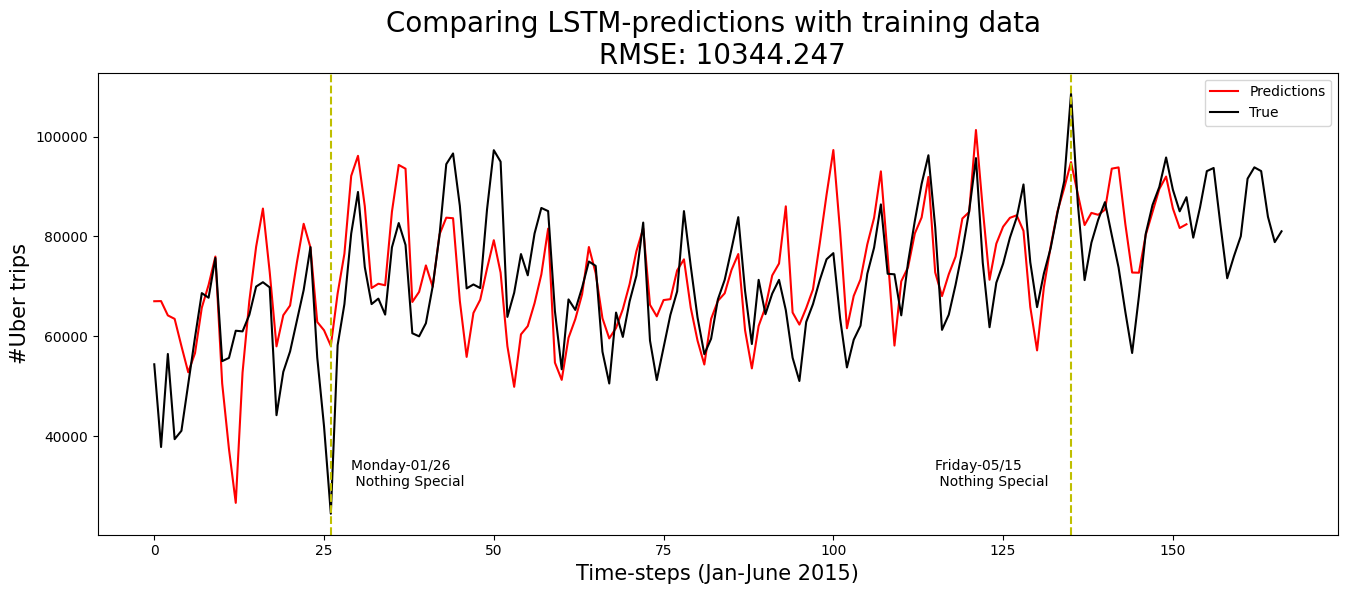

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))

ax.plot(pred_train, color = 'red', label = 'Predictions')
ax.plot(train_jan_june, color = 'black', label = 'True')

ax.axvline(x = 26, color = 'y', linestyle = 'dashed')
ax.text(x = 29, y = 30000, s = 'Monday-01/26 \n Nothing Special')

ax.axvline(x = 135, color = 'y', linestyle = 'dashed')
ax.text(x = 115, y = 30000, s = 'Friday-05/15 \n Nothing Special')

ax.set_xlabel('Time-steps (Jan-June 2015)', fontsize = 15)
ax.set_ylabel('#Uber trips', fontsize = 15)
ax.set_title('Comparing LSTM-predictions with training data \n RMSE: {}'.format(round(rmse_train,3)), fontsize = 20)

ax.legend()
plt.show()

In [ ]:
df_pred=pd.DataFrame()
df_pred['Actual_trips']=train_jan_june[0:-14].flatten()
df_pred['Predicted_trips']=pred_train

In [ ]:
df_pred.to_csv('/content/drive/My Drive/ColabNotebooks/IOT/Final Project/Final_Project_LSTM_Prediction.csv', index = None)

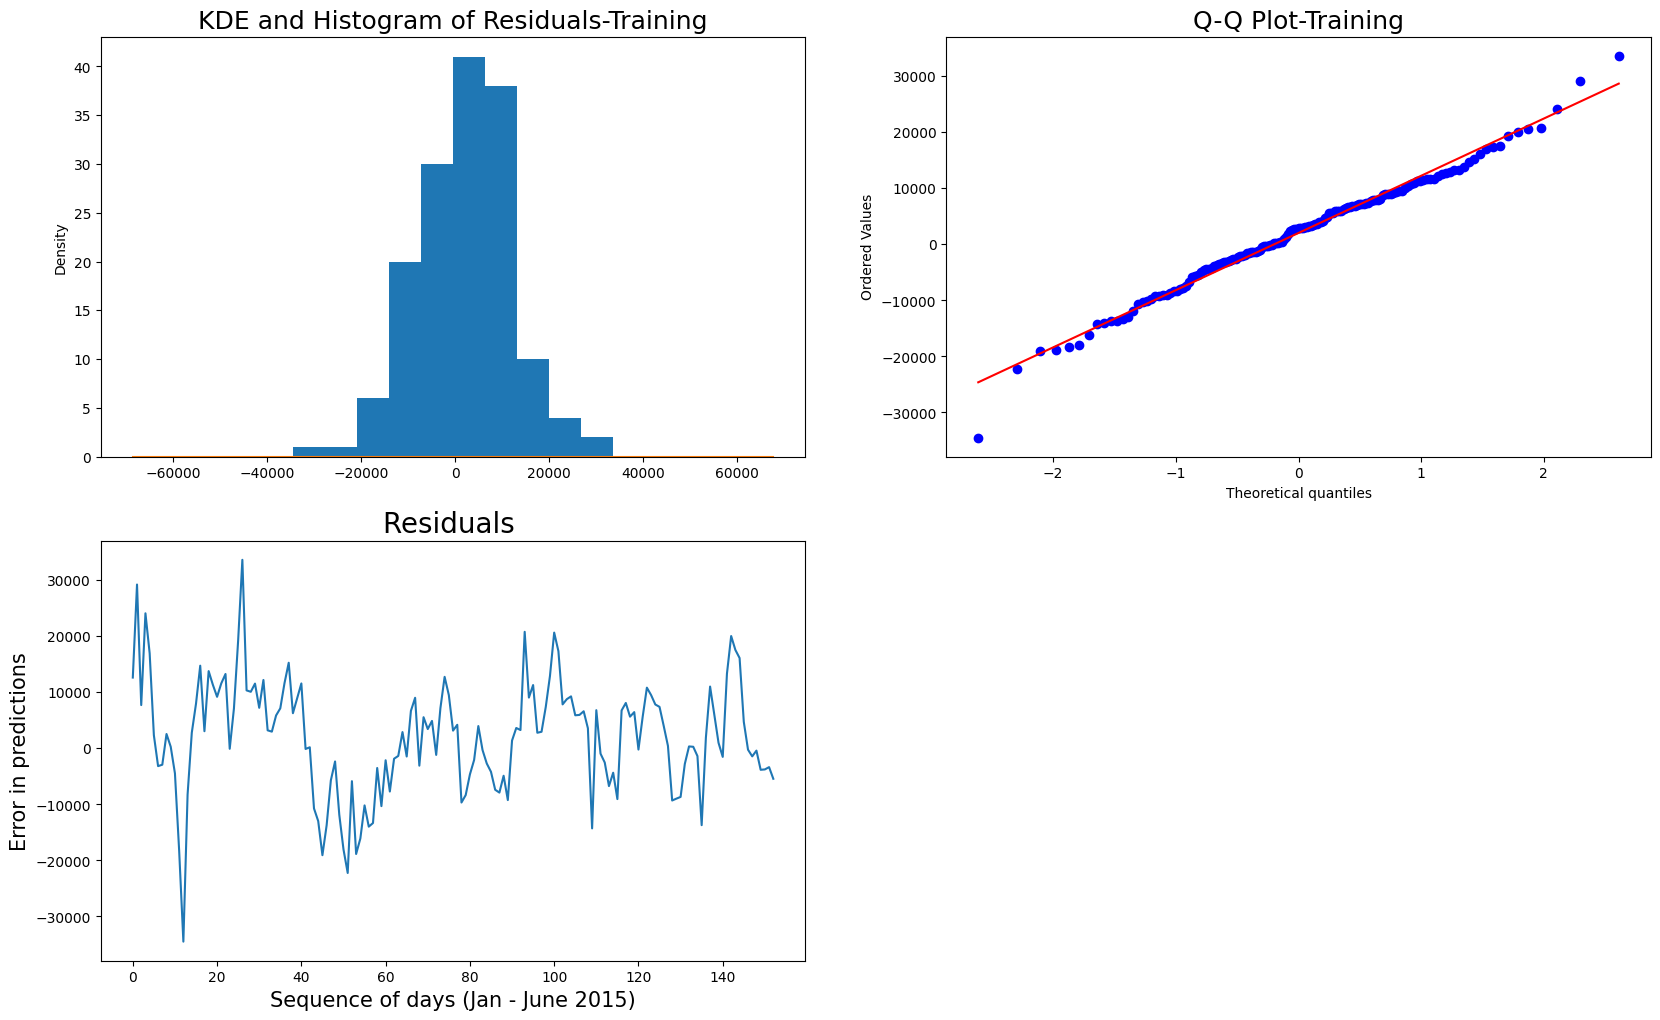

In [ ]:
import matplotlib.gridspec as gridspec
plt.figure(figsize = (20,12))
g = gridspec.GridSpec(2,2)

ax1 = plt.subplot(g[0,0])
ax1.hist(residuals_train)
pd.DataFrame(residuals_train).plot(kind = 'kde', ax = ax1, label = 'KDE')
ax1.set_title('KDE and Histogram of Residuals-Training', fontsize = 18)
ax1.legend_.remove()

ax2 = plt.subplot(g[0,1])
import scipy.stats as ss
ss.probplot(residuals_train[:,0].tolist(), plot = ax2)
ax2.set_title('Q-Q Plot-Training', fontsize = 18)

ax3 = plt.subplot(g[1,0])
ax3.plot(residuals_train)
ax3.set_xlabel('Sequence of days (Jan - June 2015)', fontsize = 15)
ax3.set_ylabel('Error in predictions', fontsize = 15)
ax3.set_title('Residuals ', fontsize = 20)

#ax4 = plt.subplot(g[1,1])
#acp(residuals_train, ax = ax4)

plt.show()